## Imports

In [2]:
import matplotlib.pyplot as plt
import time
import numpy as np
import scipy as sp 
from numba import jit, prange
from pyccel.epyccel import epyccel
from pyccel.decorators import types
import subprocess
import os
import shutil
import sys
import re
import pytest

## Pure python function

In [3]:
def solve_1d_linearconv_pure(u, un, nt, nx, dt, dx, c):

    #fill the update of u
    
    L=c*dt/dx
    for j in range(nt):
        un=[u[i] for i in range(nx)]
        for i in range(nx-1): 
            u[i+1]=(1-L)*un[i+1] +L*un[i]   # or un[i]=(1-L)*un[i] +L*un[i-1]  "and for start from 1 "
    return 0

## Numba accelerator

In [4]:
@jit(fastmath=True,parallel=True)
def solve_1d_linearconv_numba(u, un, nt, nx, dt, dx, c):

    for j in prange(nt):
        un=u.copy()
        for i in prange(nx-1): 
            u[i+1]=(1-c*dt/dx)*un[i+1] +c*dt/dx*un[i]   # or un[i]=(1-L)*un[i] +L*un[i-1]  "and for start from 1 "

    #fill the update of u
    return 0

## Pyccel accelerator

In [5]:
@types('float[:]', 'float[:]','int','int','float','float','float')
def solve_1d_linearconv_f90(u, un, nt, nx, dt, dx, c):
    for j in range(nt):
        un[:]=u[:]
        for i in range(nx-1): 
            u[i+1]=(1-c*(dt/dx))*un[i+1] +c*(dt/dx)*un[i]   # or un[i]=(1-L)*un[i] +L*un[i-1]  "and for start from 1 "
    return 0
   

## Inputs

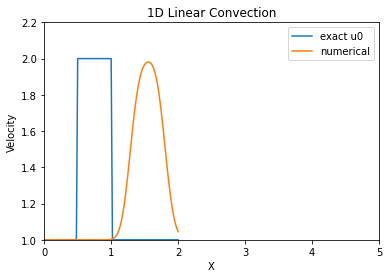

In [12]:
import ipywidgets
%matplotlib inline
nx = 105  # try changing this number from 41 to 81 and Run All ... what happens?
dx = 2 / (nx-1)
nt = 200    #nt is the number of timesteps we want to calculate
c = 1.0     #assume wavespeed of c = 1
dt = 0.004
grid = np.linspace(0,2,nx) # creating the space grid    

u0 = np.ones(nx)      #numpy function ones()
u0[int(.5 / dx):int(1 / dx + 1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s
#plt.plot(grid,u0)
u = u0.copy()
un = np.ones(nx)

solve_1d_linearconv_pure(u, un, nt, nx, dt, dx, c)


#Plotting data
plt.plot(grid,u0,label="exact u0")
plt.plot(grid,u,label="numerical")
plt.ylim([1.,2.2])
plt.xlim([0,5])
plt.xlabel('X')
plt.ylabel('Velocity')    
plt.title('1D Linear Convection')
plt.legend()


## Call Funtions

### Pure function

In [8]:
%timeit solve_1d_linearconv_pure(u, un, nt, nx, dt, dx, c)

10.6 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Function with numba accelerator

In [9]:
%timeit solve_1d_linearconv_numba(u, un, nt, nx, dt, dx, c)

33.9 µs ± 8.08 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)



### Function with pyccel accelerator

In [10]:
solve_1d_linearconv_f90 = epyccel(solve_1d_linearconv_f90 )


In [11]:
%timeit solve_1d_linearconv_f90(u, un, nt, nx, dt, dx, c)

10.8 µs ± 72 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Another example with OpenMP

In [10]:
@types('float[:,:](order=C)','float[:,:](order=F)','float[:,:](order=C)')
def dot(a, b, c):
    m, p = a.shape
    q, n = b.shape
    r, s = c.shape
    if p != q or m != r or n != s:
        return-1
    #$ omp parallel
    #$ omp do schedule(runtime)
    for i in range(m):
        for j in range(n):
            c[i, j] = 0.0
            for k in range(p):
                c[i, j] += a[i, k] * b[k, j]
    #$ omp end do
    #$ omp end parallel
    return 0

In [11]:

dot_f90 = epyccel(dot, accelerator='openmp')
m, n, p = 100, 150, 200
a = np.random.random((m, p))
b = np.random.random((n, p)).transpose()
%timeit c = np.empty((m, n)); dot_f90(a, b, c)

1.33 ms ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
